In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [3]:
adata = anndata.read_h5ad("../Lung_two_species_raw.h5ad")
adata
# Assuming your AnnData object is named adata
adata.obs.rename(columns={'celltype': 'cell_type'}, inplace=True)
adata

AnnData object with n_obs × n_vars = 20760 × 62781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'cell_type', 'species', 'batch', 'BATCH'
    var: 'genename-0', 'genename-1'

In [4]:
unique_batches = adata.obs['batch'].unique()
unique_batches

['0', '1']
Categories (2, object): ['0', '1']

Because Lung two species only have two batches, we set one of them to have no cell annotations.

### Setting: Only batch = 1 have annotations

In [5]:
import numpy as np

# Initialize all labels with "Unknown"
adata.obs['batch_labels'] = "Unknown"

# Assign labels only to the specified batch (batch = 0 in this case)
target_batch = "1"
annotated_indices = adata.obs[adata.obs['batch'] == target_batch].index
adata.obs.loc[annotated_indices, 'batch_labels'] = adata.obs.loc[annotated_indices, 'cell_type']

# Convert the 'batch_labels' column to category type
adata.obs['batch_labels'] = adata.obs['batch_labels'].astype('category')

In [6]:
# Save the new_labels column to a CSV file
adata.obs.to_csv('../R_lung_two_species/labels/partially_annotated_batches_lung_two_species_1.csv', index=True)

In [5]:
adata.obs['batch_labels'] = pd.read_csv('../R_lung_two_species/labels/partially_annotated_batches_lung_two_species_1.csv')['batch_labels'].values

In [6]:
adata.obs['batch_labels'] = adata.obs['batch_labels'].astype('category')

In [7]:
adata.obs['batch_labels']

HC1__AAATGCCTCTGCAAGT-0     Mac_inter
HC1__TTGACTTAGTGGAGAA-0       Unknown
HC1__TTCTCAACAGCCTATA-0       Unknown
HC1__GCAGTTATCCCTCTTT-0       Unknown
HC1__TCTTTCCTCGGCCGAT-0       Unknown
                              ...    
fMouseTGAAAGACAATTGCTG-1     Ciliated
fMouseTGGACGCAGTGCAAGC-1     Ciliated
fMouseTTCCCAGTCCATGAGT-1     Ciliated
fMouseTTCTCAAAGATCACGG-1     Ciliated
fMouseTTGGAACGTAACGTTC-1     Ciliated
Name: batch_labels, Length: 20760, dtype: category
Categories (18, object): ['ATI', 'ATII', 'B_Jchain+', 'B_cells', ..., 'Secretory', 'T_CD8+', 'T_cells', 'Unknown']

In [8]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [9]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# scANVI

In [ ]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [10]:
import scvi

# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


In [11]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

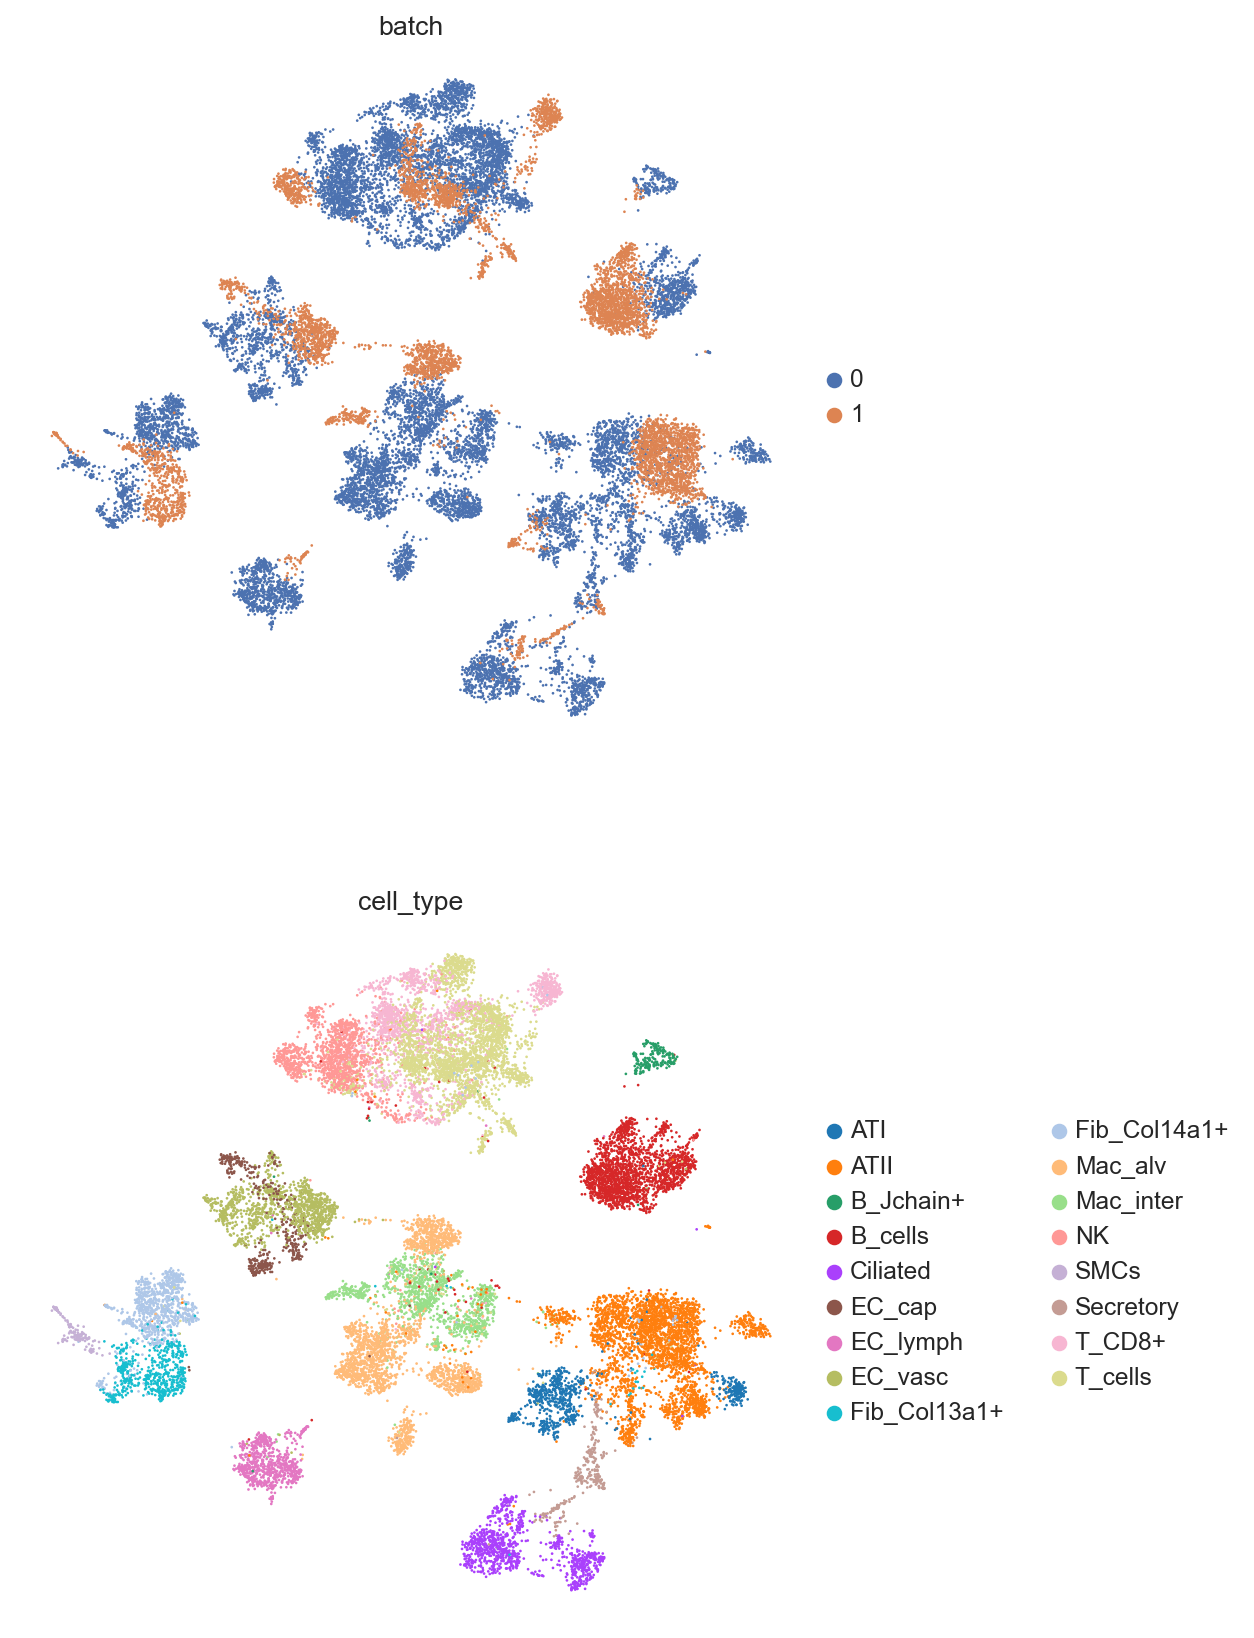

In [12]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [13]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="batch_labels",
    unlabeled_category="Unknown",
)

In [14]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [03:15<00:00,  9.97s/it, v_num=1, train_loss_step=456, train_loss_epoch=436]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [03:15<00:00,  9.79s/it, v_num=1, train_loss_step=456, train_loss_epoch=436]


In [15]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [16]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict['X_scANVI'] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [17]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

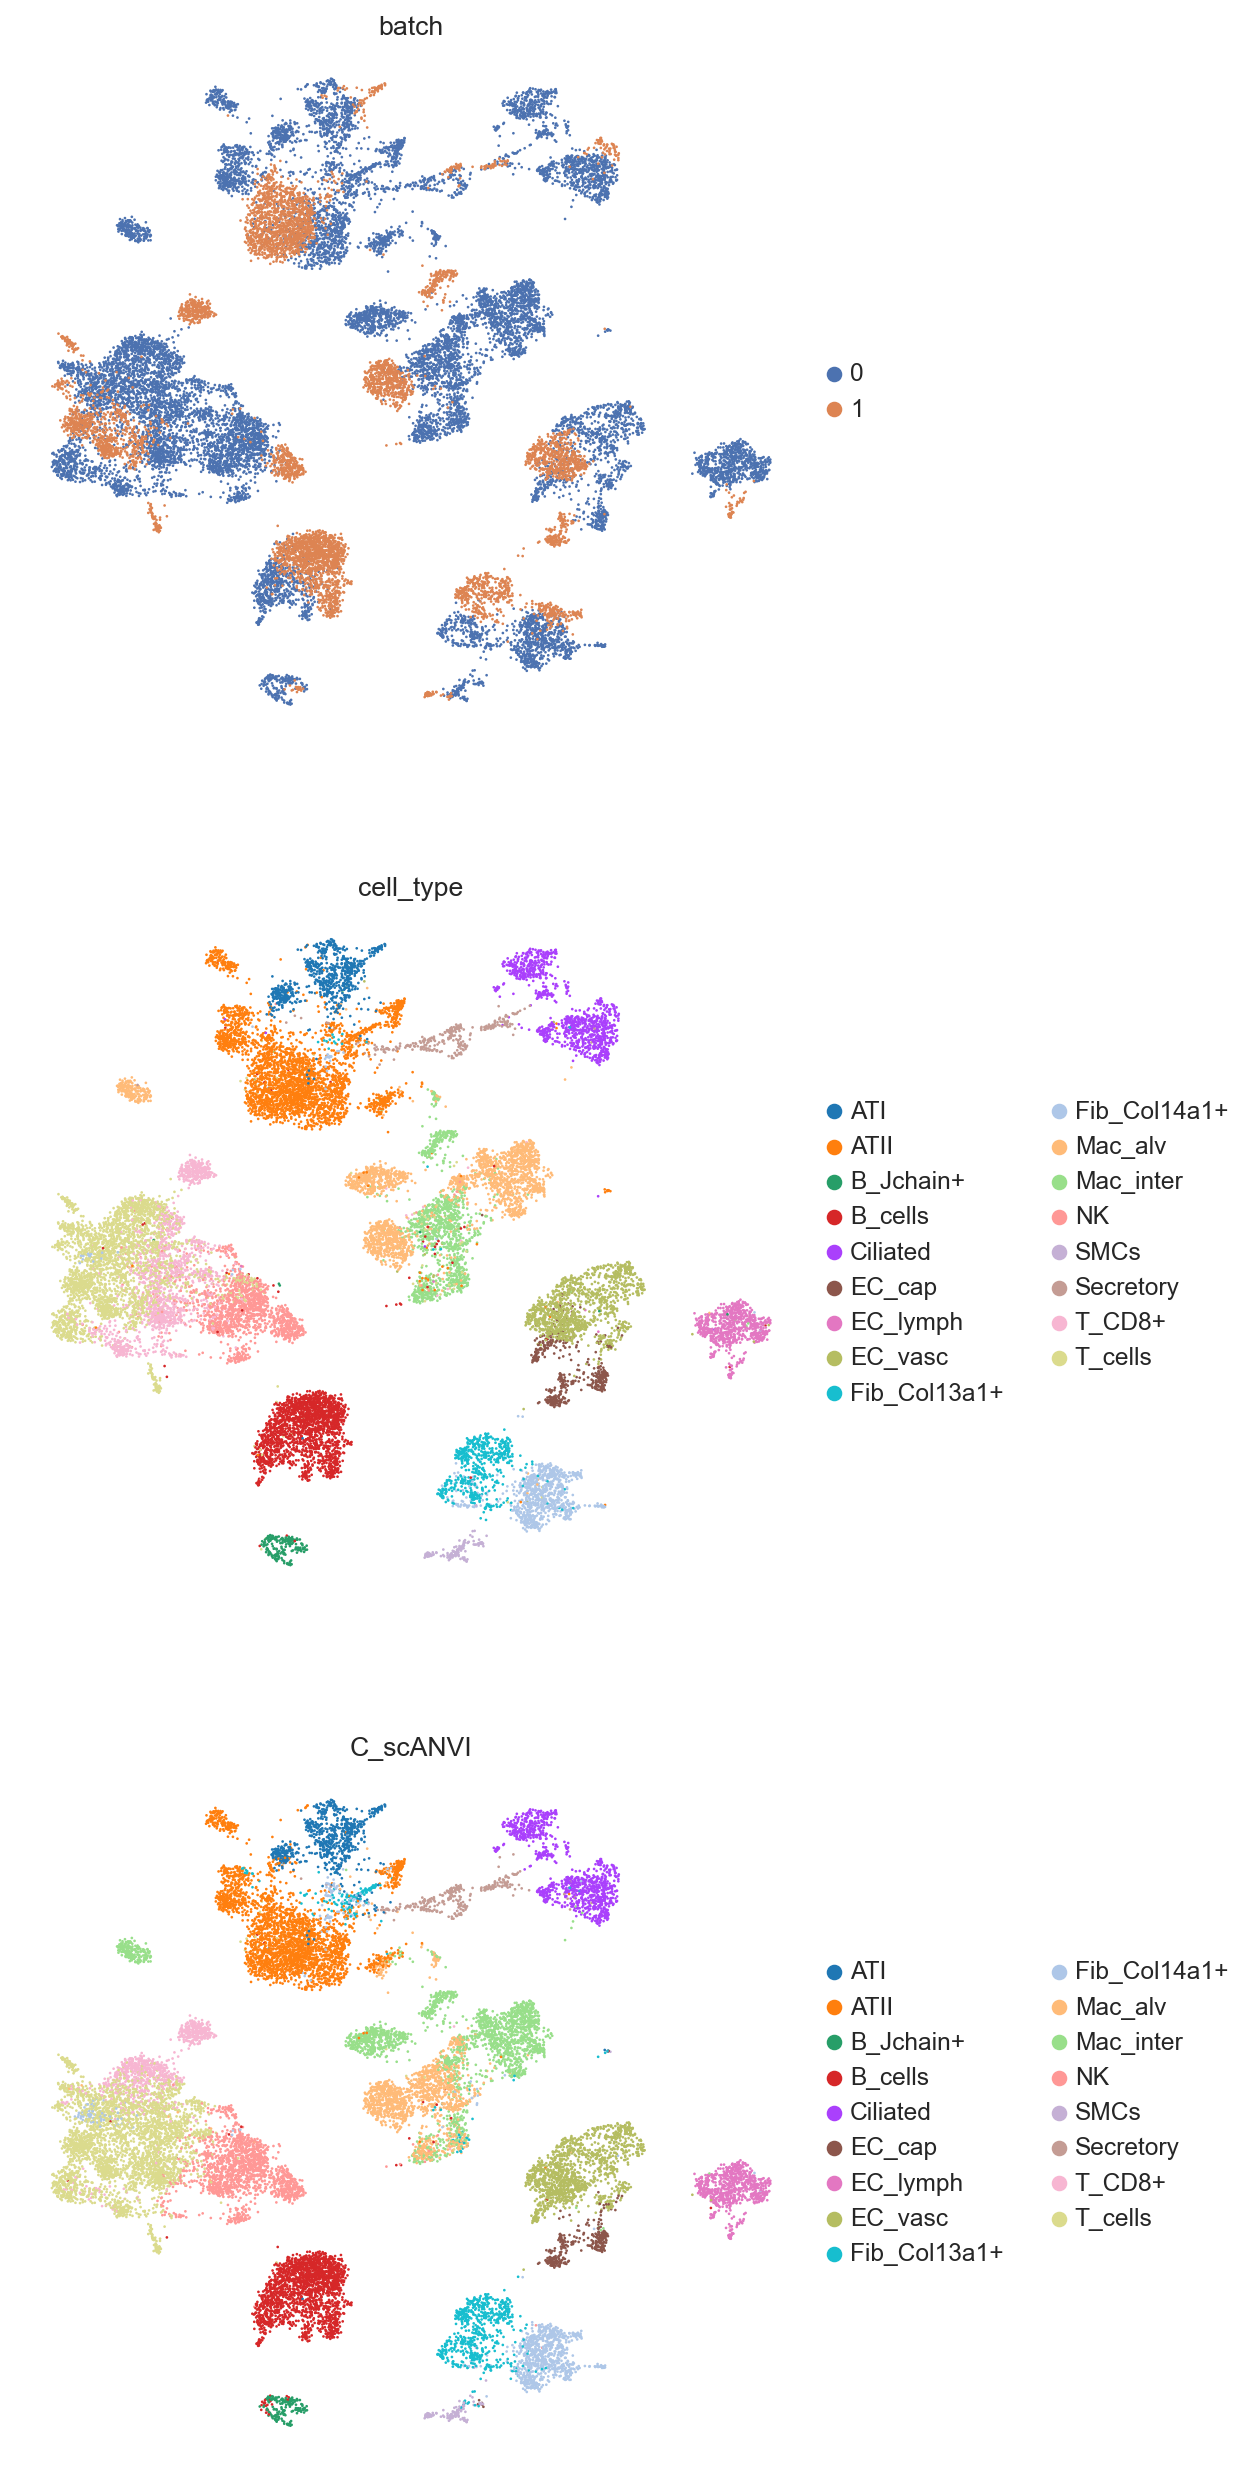

In [18]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata

In [19]:
train = adata.copy()

### Preprocessing Data

In [20]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="batch_labels")

## Creating and Training the model¶

In [21]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 27/100:  27%|██▋       | 27/100 [12:33<33:58, 27.92s/it, v_num=1, train_loss_step=83.9, train_loss_epoch=81.1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 734.938. Signaling Trainer to stop.


## Batch-Removal

In [22]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 20760 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'cell_type', 'species', 'batch', 'BATCH', 'batch_labels', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'concat_batch'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [23]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [24]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

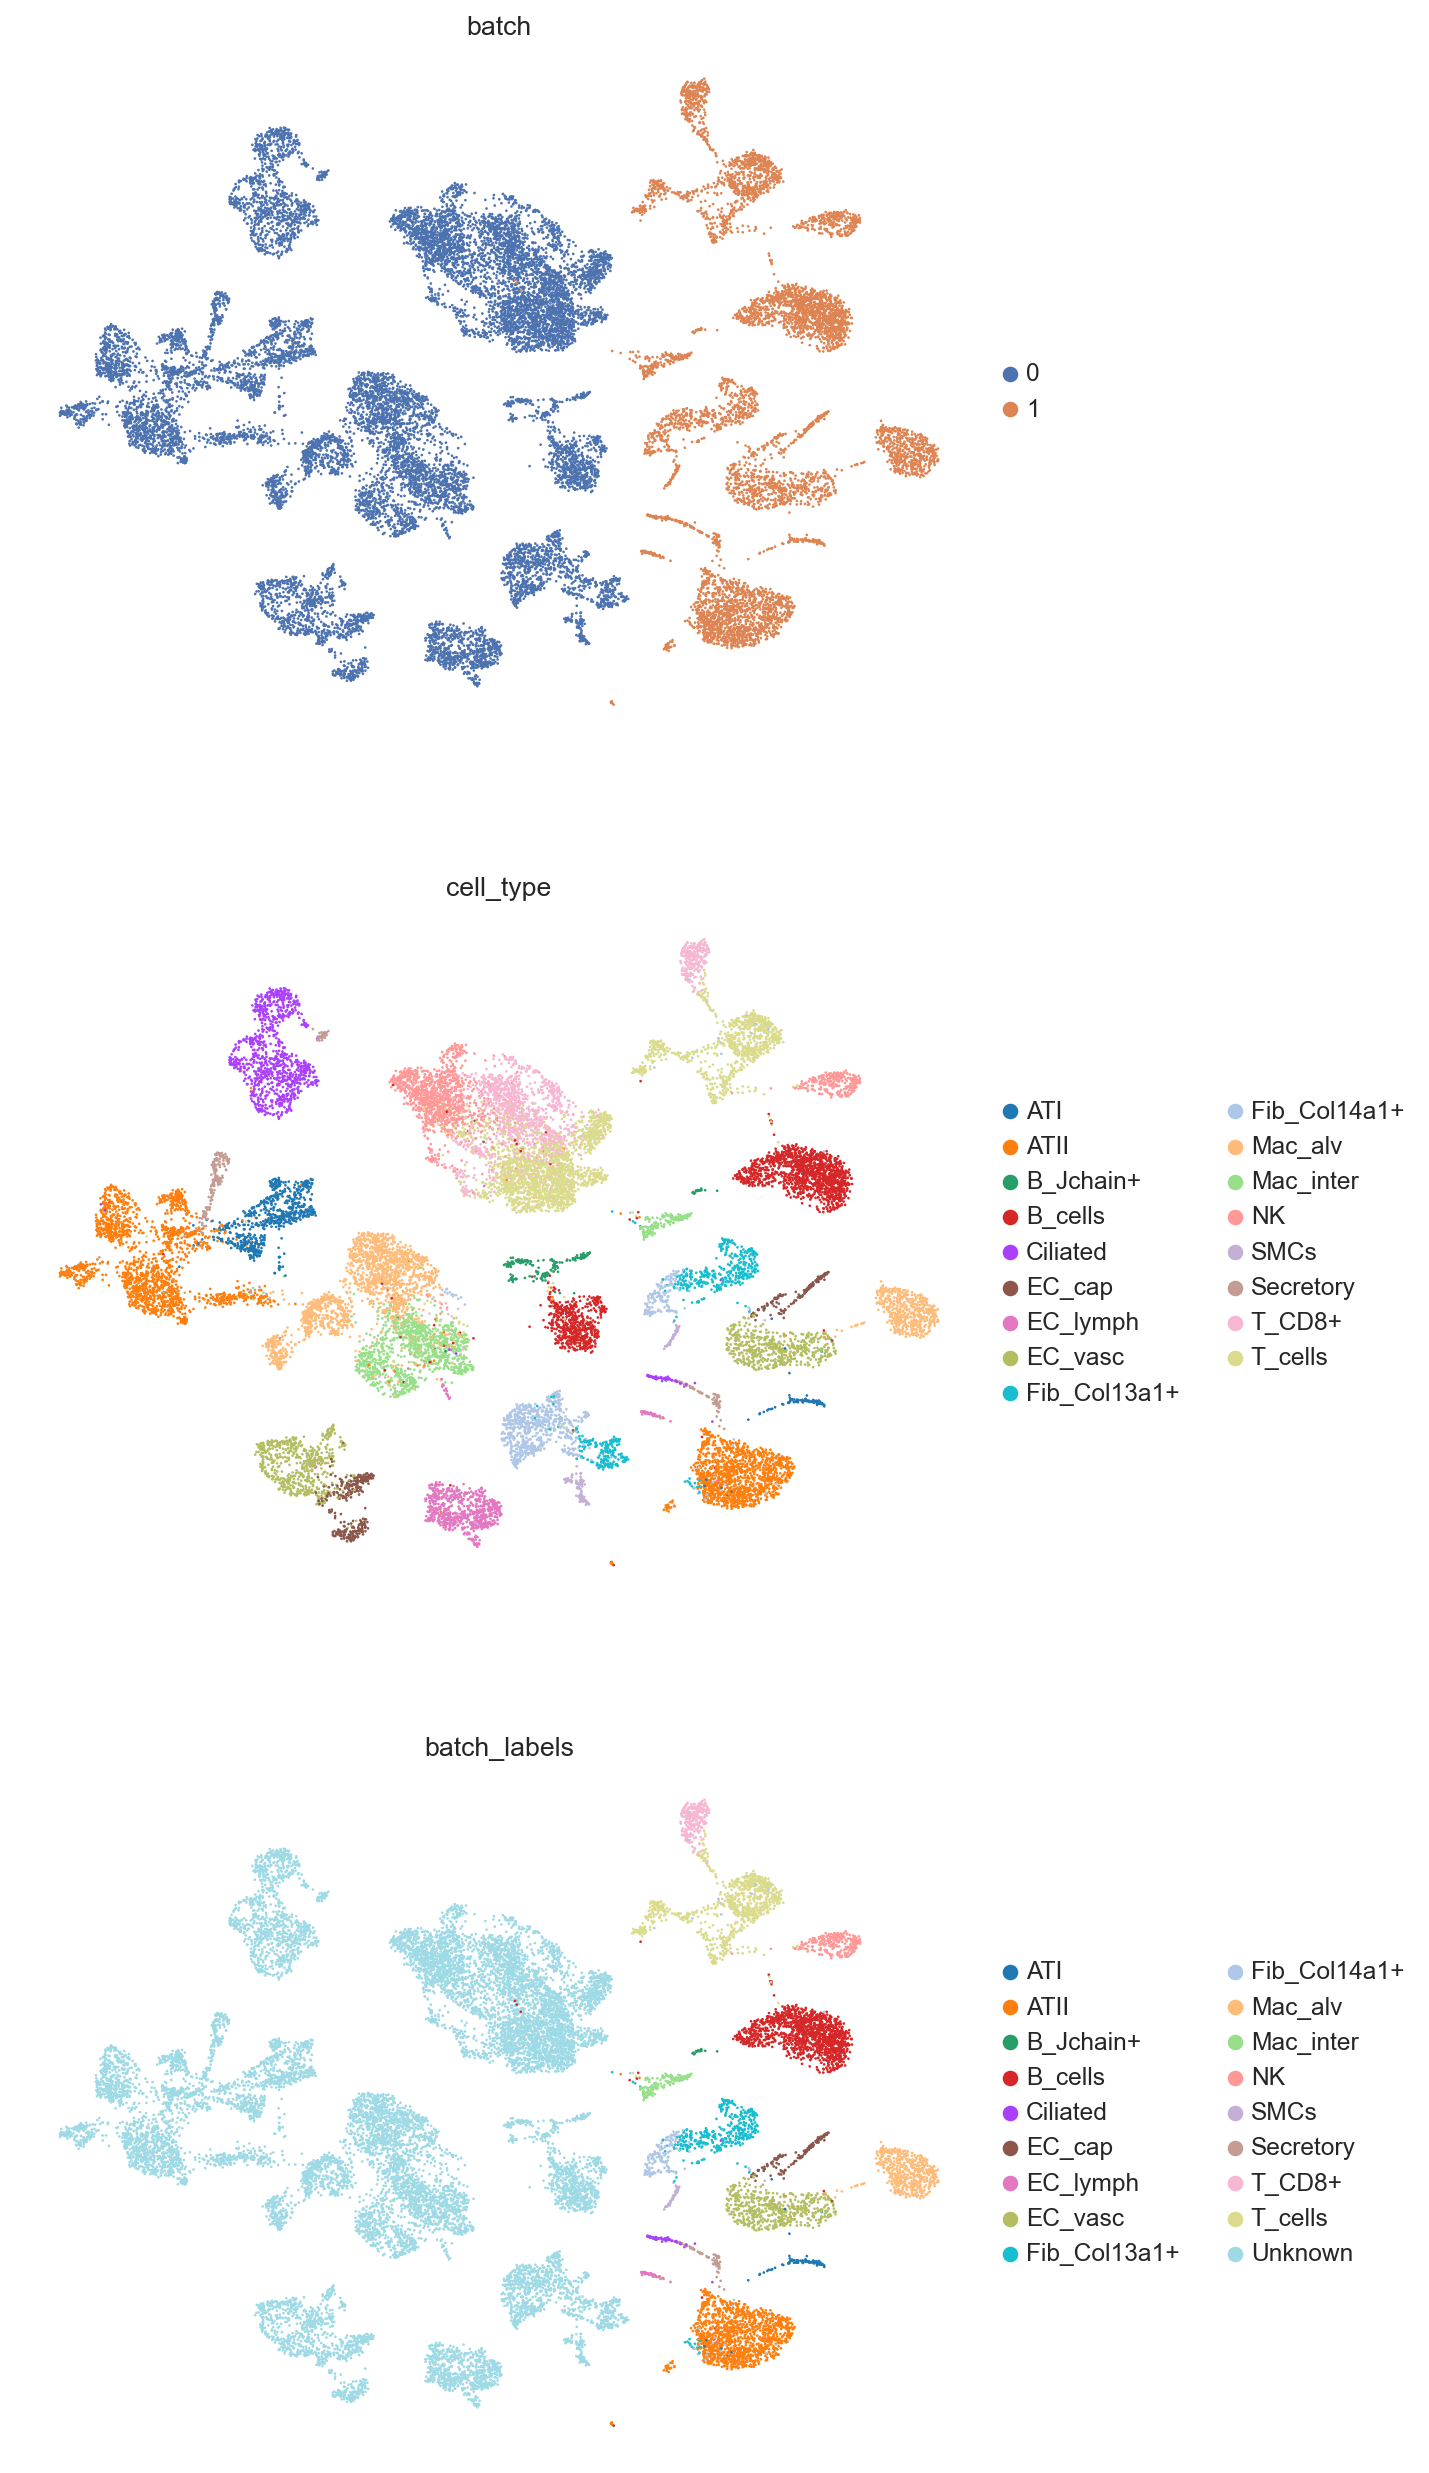

In [25]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type', 'batch_labels'], wspace=0.4, frameon=False, ncols=1)

Seems that scGEN will treat the whole un-annotated batch as a new cell type and do no integration on it.

# STACAS

In [ ]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type', 'batch_labels'], wspace=0.4, frameon=False, ncols=1)

Semi-supervised integration results

stacas will behave in unsupervised mode when cell type annotations are available for only one of the batches, so we skip this method for this setting.

In [ ]:
pca_embeddings = pd.read_csv('../R_lung_two_species/embeddings/lung_two_species_stacas_embeddings_partially_annotated_batches_0.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [ ]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

In [ ]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# scDREAMER

In [26]:
pca_embeddings = pd.read_csv('../R_lung_two_species/embeddings/partially_annotated_lung_two_species_scdreamer_embeddings_1.csv', index_col=0)
adata.obsm['X_scDREAMER'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_scDREAMER")
sc.tl.umap(adata, min_dist=0.5)

In [27]:
# Collect embeddings
embeddings_dict["X_scDREAMER"] = pca_embeddings.values

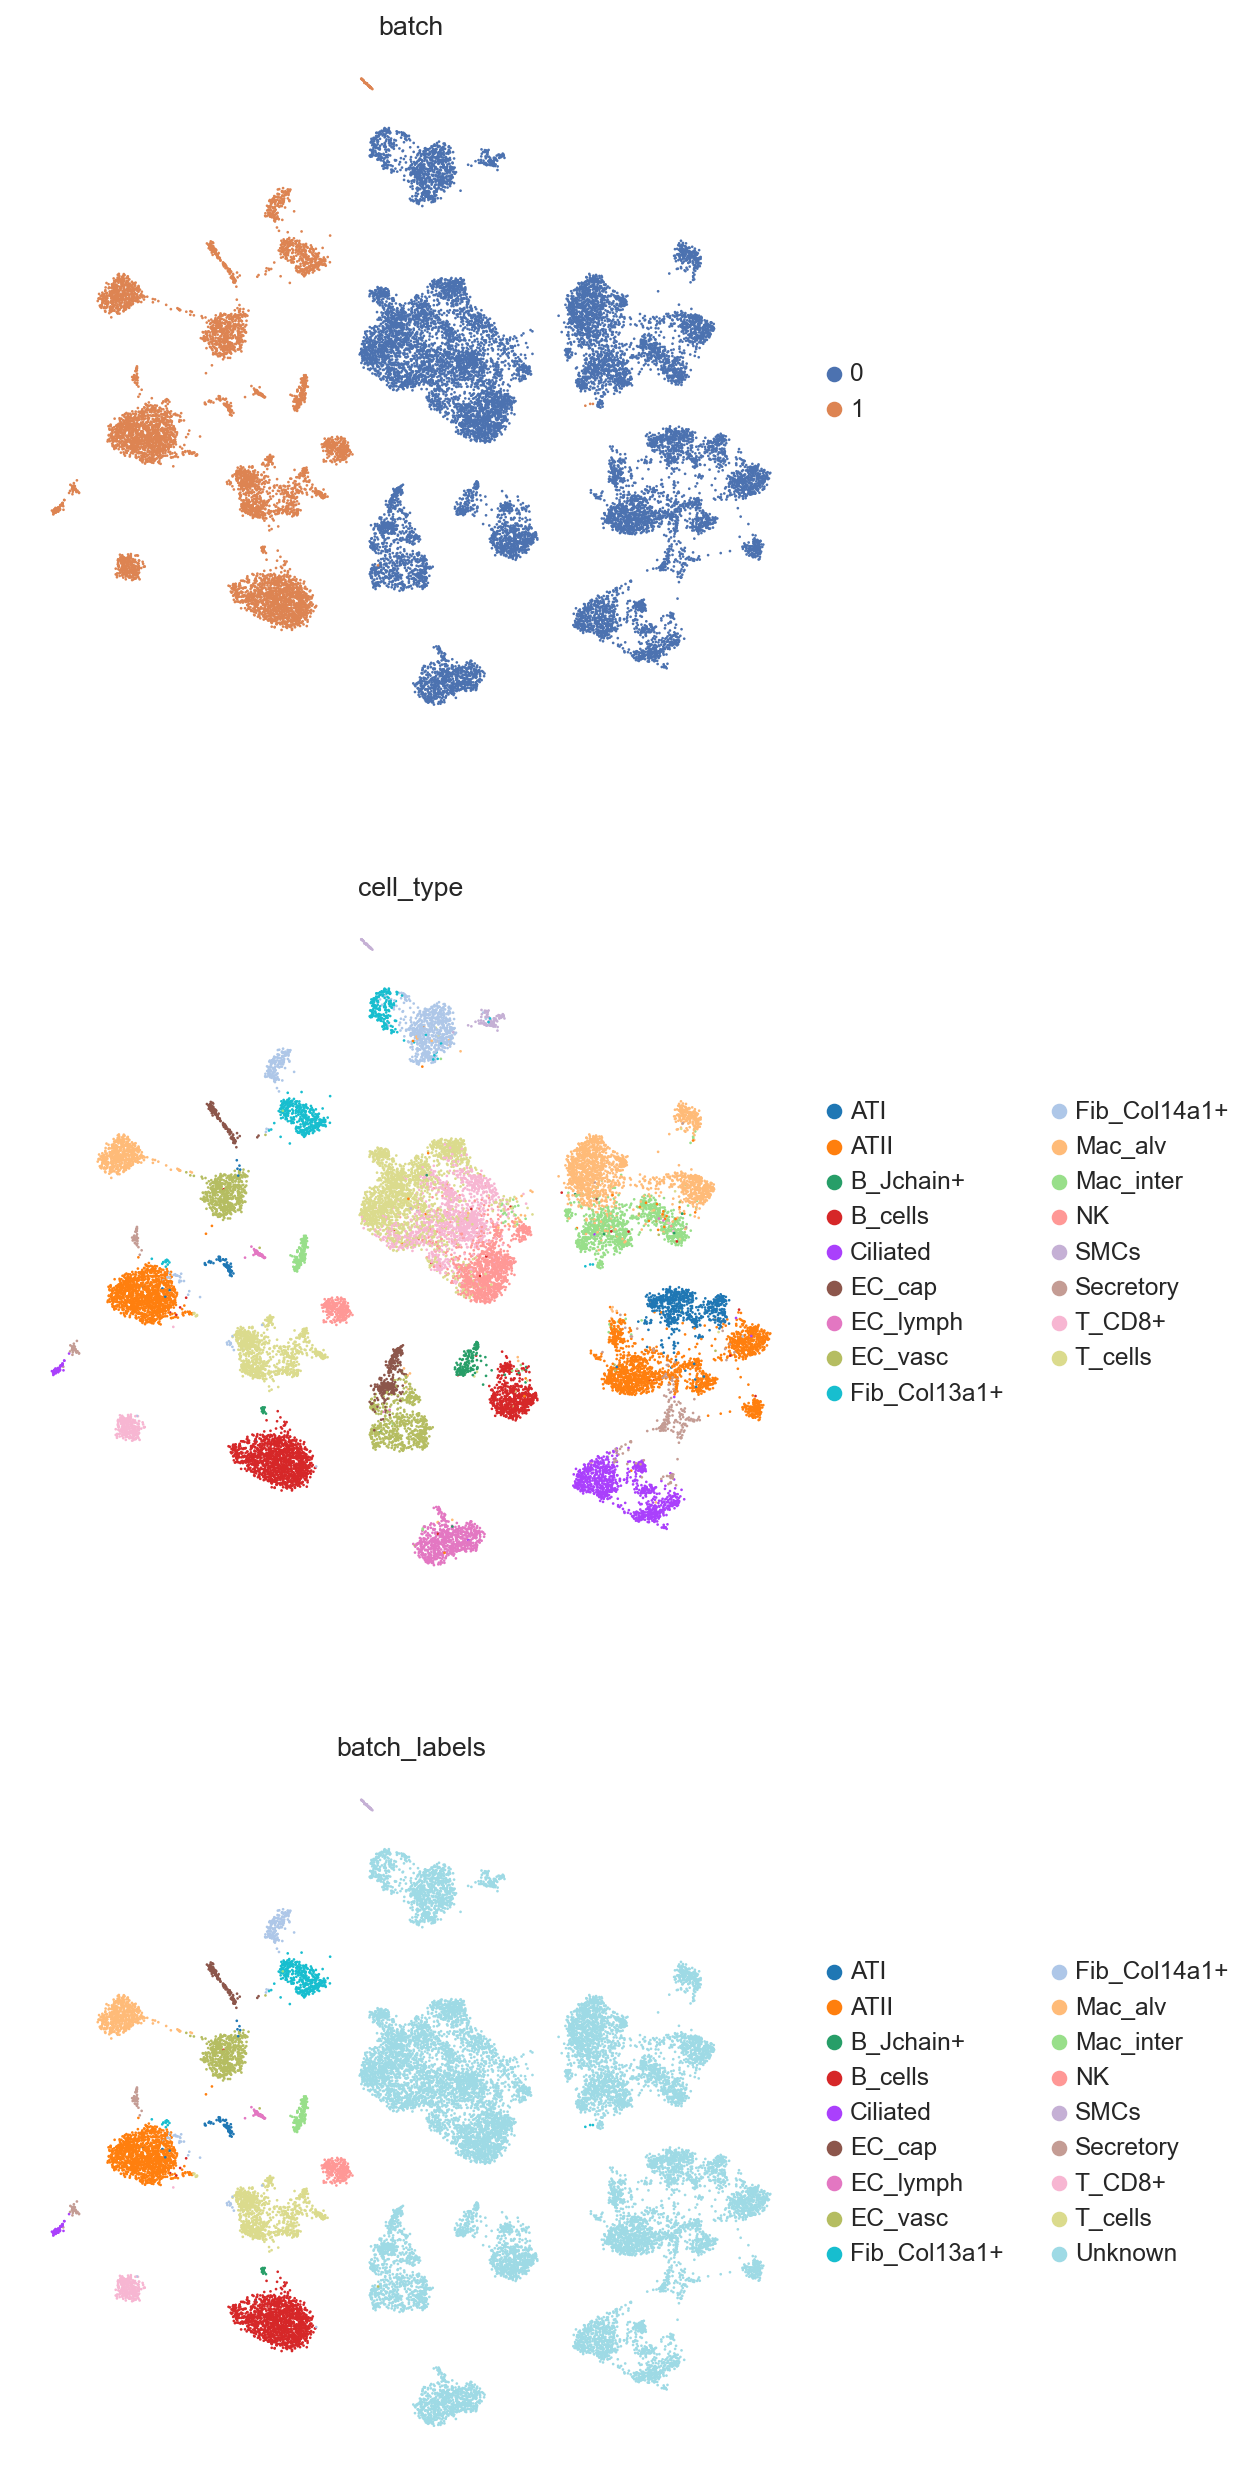

In [28]:
sc.pl.umap(adata, color=["batch", "cell_type", "batch_labels"], frameon=False, ncols=1)

# ItClust

In [29]:
pca_embeddings = pd.read_csv('../R_lung_two_species/embeddings/partially_annotated_lung_two_species_itclust_embeddings_1.csv', index_col=0)
adata.obsm['X_itclust'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_itclust")
sc.tl.umap(adata, min_dist=0.5)

In [30]:
# Collect embeddings
embeddings_dict["X_itclust"] = pca_embeddings.values

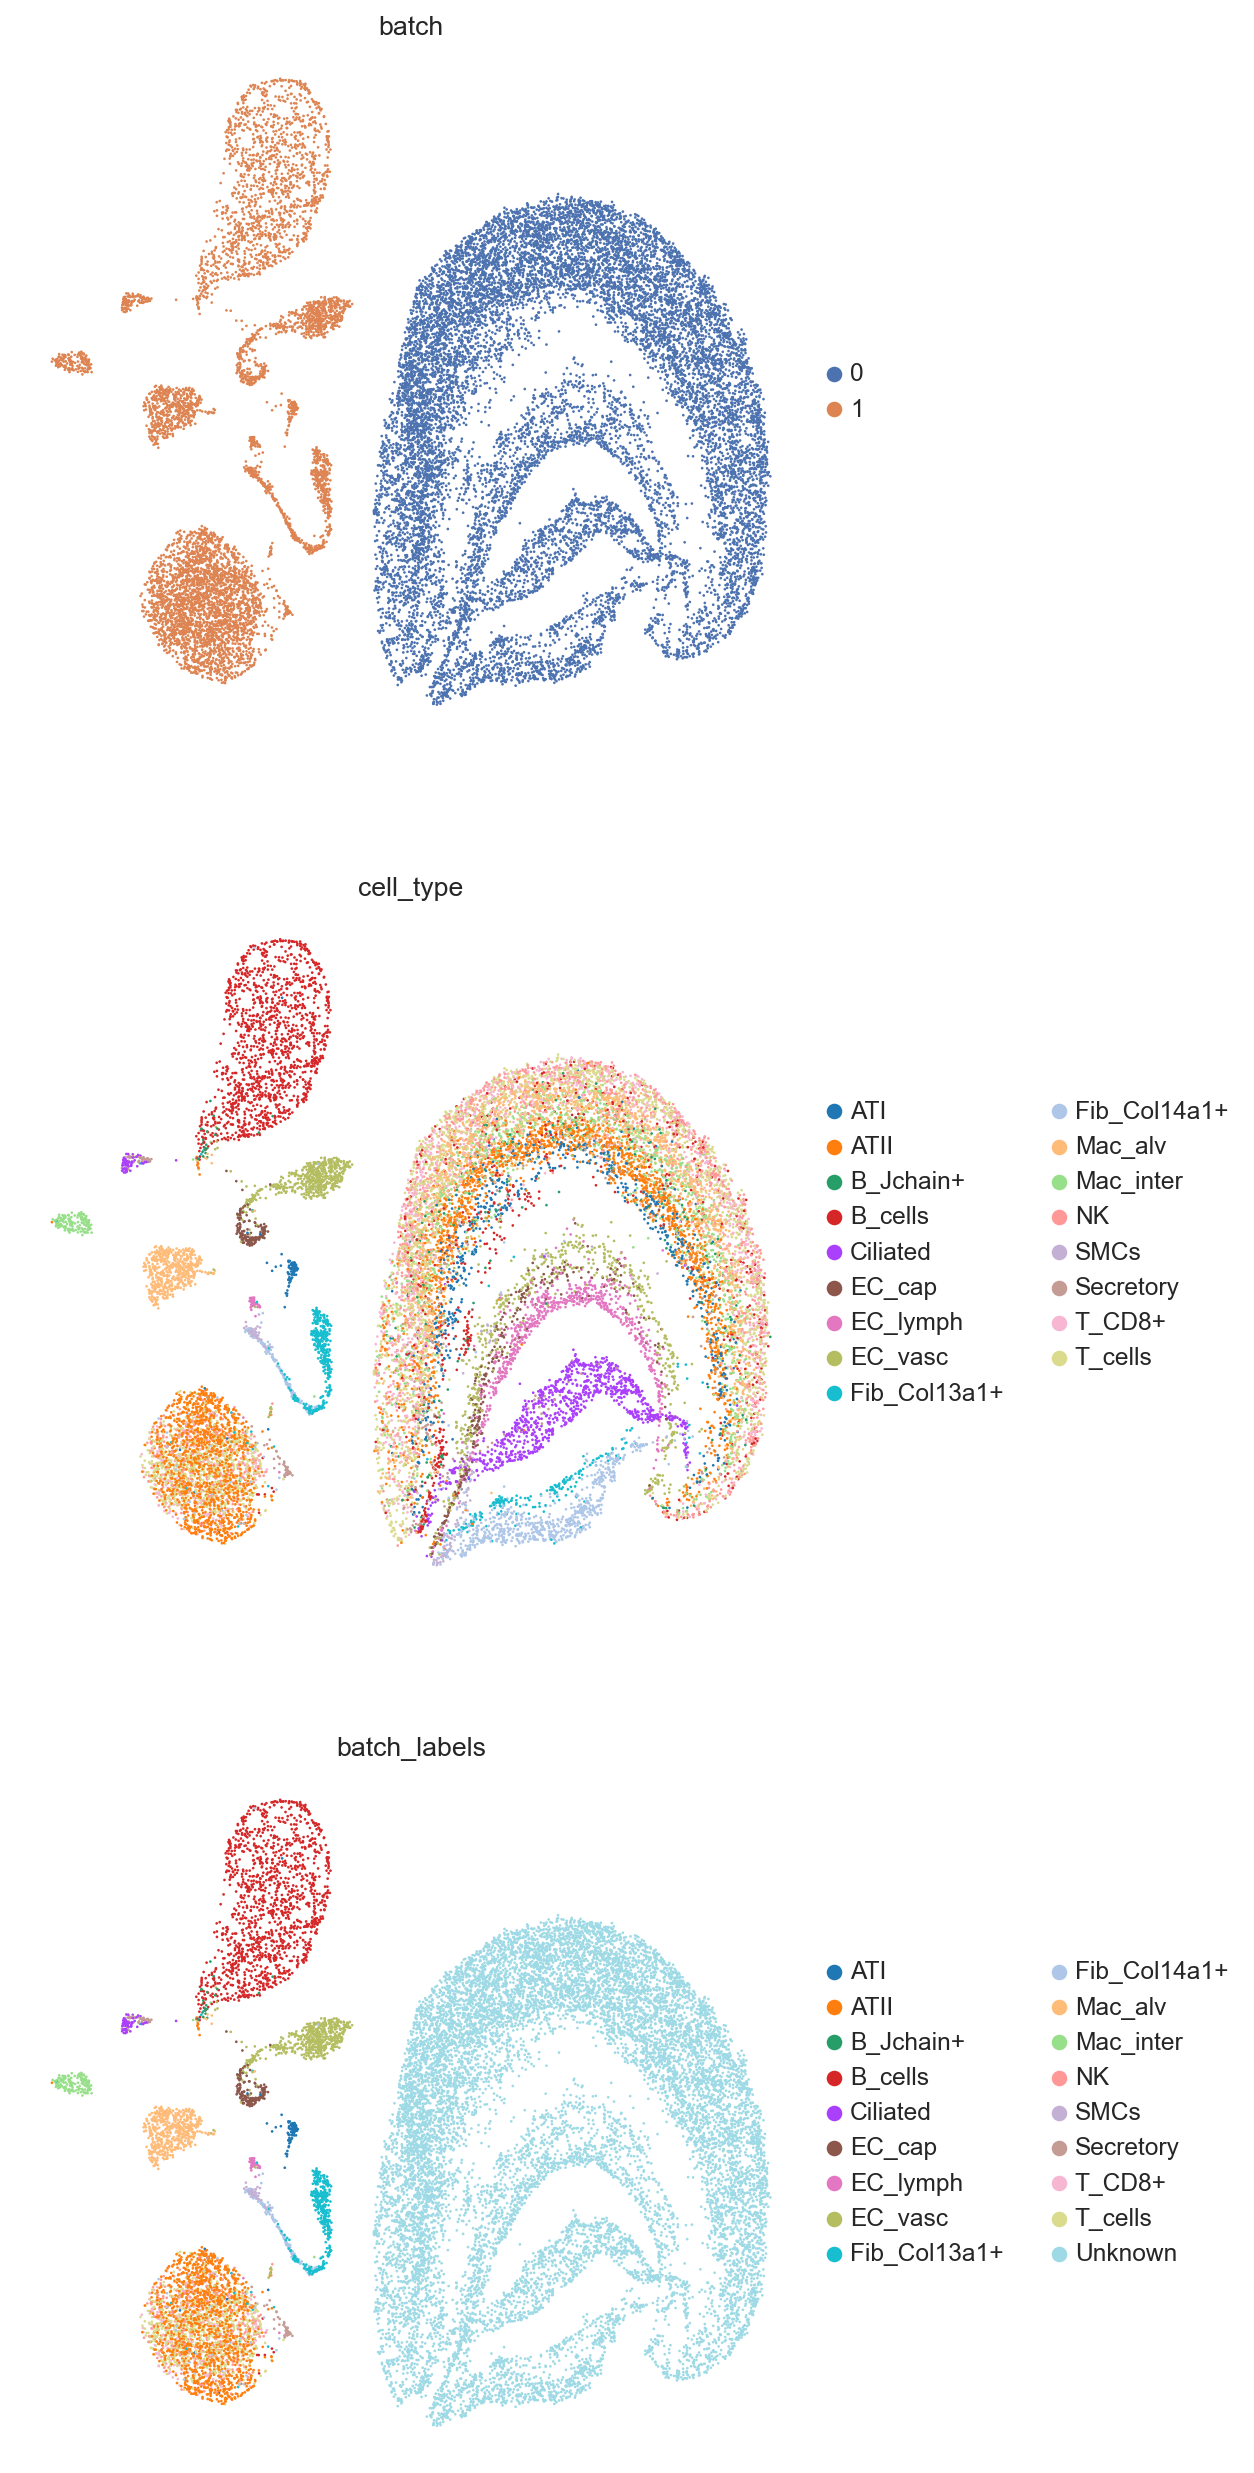

In [31]:
sc.pl.umap(adata, color=["batch", "cell_type", "batch_labels"], frameon=False, ncols=1)

In [32]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/partially_annotated_batches_lung_two_species_1.csv")


# Metric Evaluation

## read the embeddings

In [90]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/partially_annotated_batches_lung_two_species_0.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

In [ ]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df

In [97]:
merged_df.to_csv("../metrics/lung_two_species_metrics_partially_annotated_0.csv", index=True)

In [ ]:
merged_df